In [1]:
#public data integration
import os
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import numpy as np
import useful_functions as uf
import scvi
sc.set_figure_params(figsize=(6, 6))
import sys
print(sys.executable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import scarches as sca

Global seed set to 0
/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
 captum (see https://github.com/pytorch/captum).


/nfs/team297/bs16/tools/conda_envs/scvi-env/bin/python3.9


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(pd.__version__)
print(scvi.__version__)
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')


1.9.1
0.8.0
1.5.1
0.19.0


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/raw/public_data')
adata = sc.read_h5ad('./public_kidney_adata.h5ad')

In [4]:
adata = adata[:, adata.var['highly_variable']]

In [5]:
adata.obs['annotated_celltype'].value_counts()

unknown                                  141648
Proximal tubule                           17555
CD4 T cell                                 2411
NK cell                                    1320
CD8 T cell                                  987
B cell                                      946
NKT cell                                    728
Thick ascending limb of Loop of Henle       666
Peritubular capillary endothelium 1         666
Glomerular endothelium                      622
MNP-a/classical monocyte derived            533
Indistinct intercalated cell                392
MNP-b/non-classical monocyte derived        369
Ascending vasa recta endothelium            300
Type A intercalated cell                    272
Proliferating Proximal Tubule               263
Epithelial progenitor cell                  237
MNP-c/dendritic cell                        214
Descending vasa recta endothelium           192
Peritubular capillary endothelium 2         185
Connecting tubule                       

In [6]:
adata = adata.copy()

In [7]:
#compute an SCVI model
sca.models.SCVI.setup_anndata(adata, categorical_covariate_keys = ['donor', 'dataset'],
                             #continuous_covariate_keys = ['dissociation_stress_score'],
                              labels_key = 'annotated_celltype',
                              layer = 'counts')

In [8]:
vae = sca.models.SCVI(adata, n_layers = 2, n_latent = 30)

In [9]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47/47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [14:46<00:00, 16.78s/it, loss=128, v_num=1]

`Trainer.fit` stopped: `max_epochs=47` reached.


Epoch 47/47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [14:46<00:00, 18.87s/it, loss=128, v_num=1]


In [10]:
adata.obsm['X_scVI'] = vae.get_latent_representation(adata)

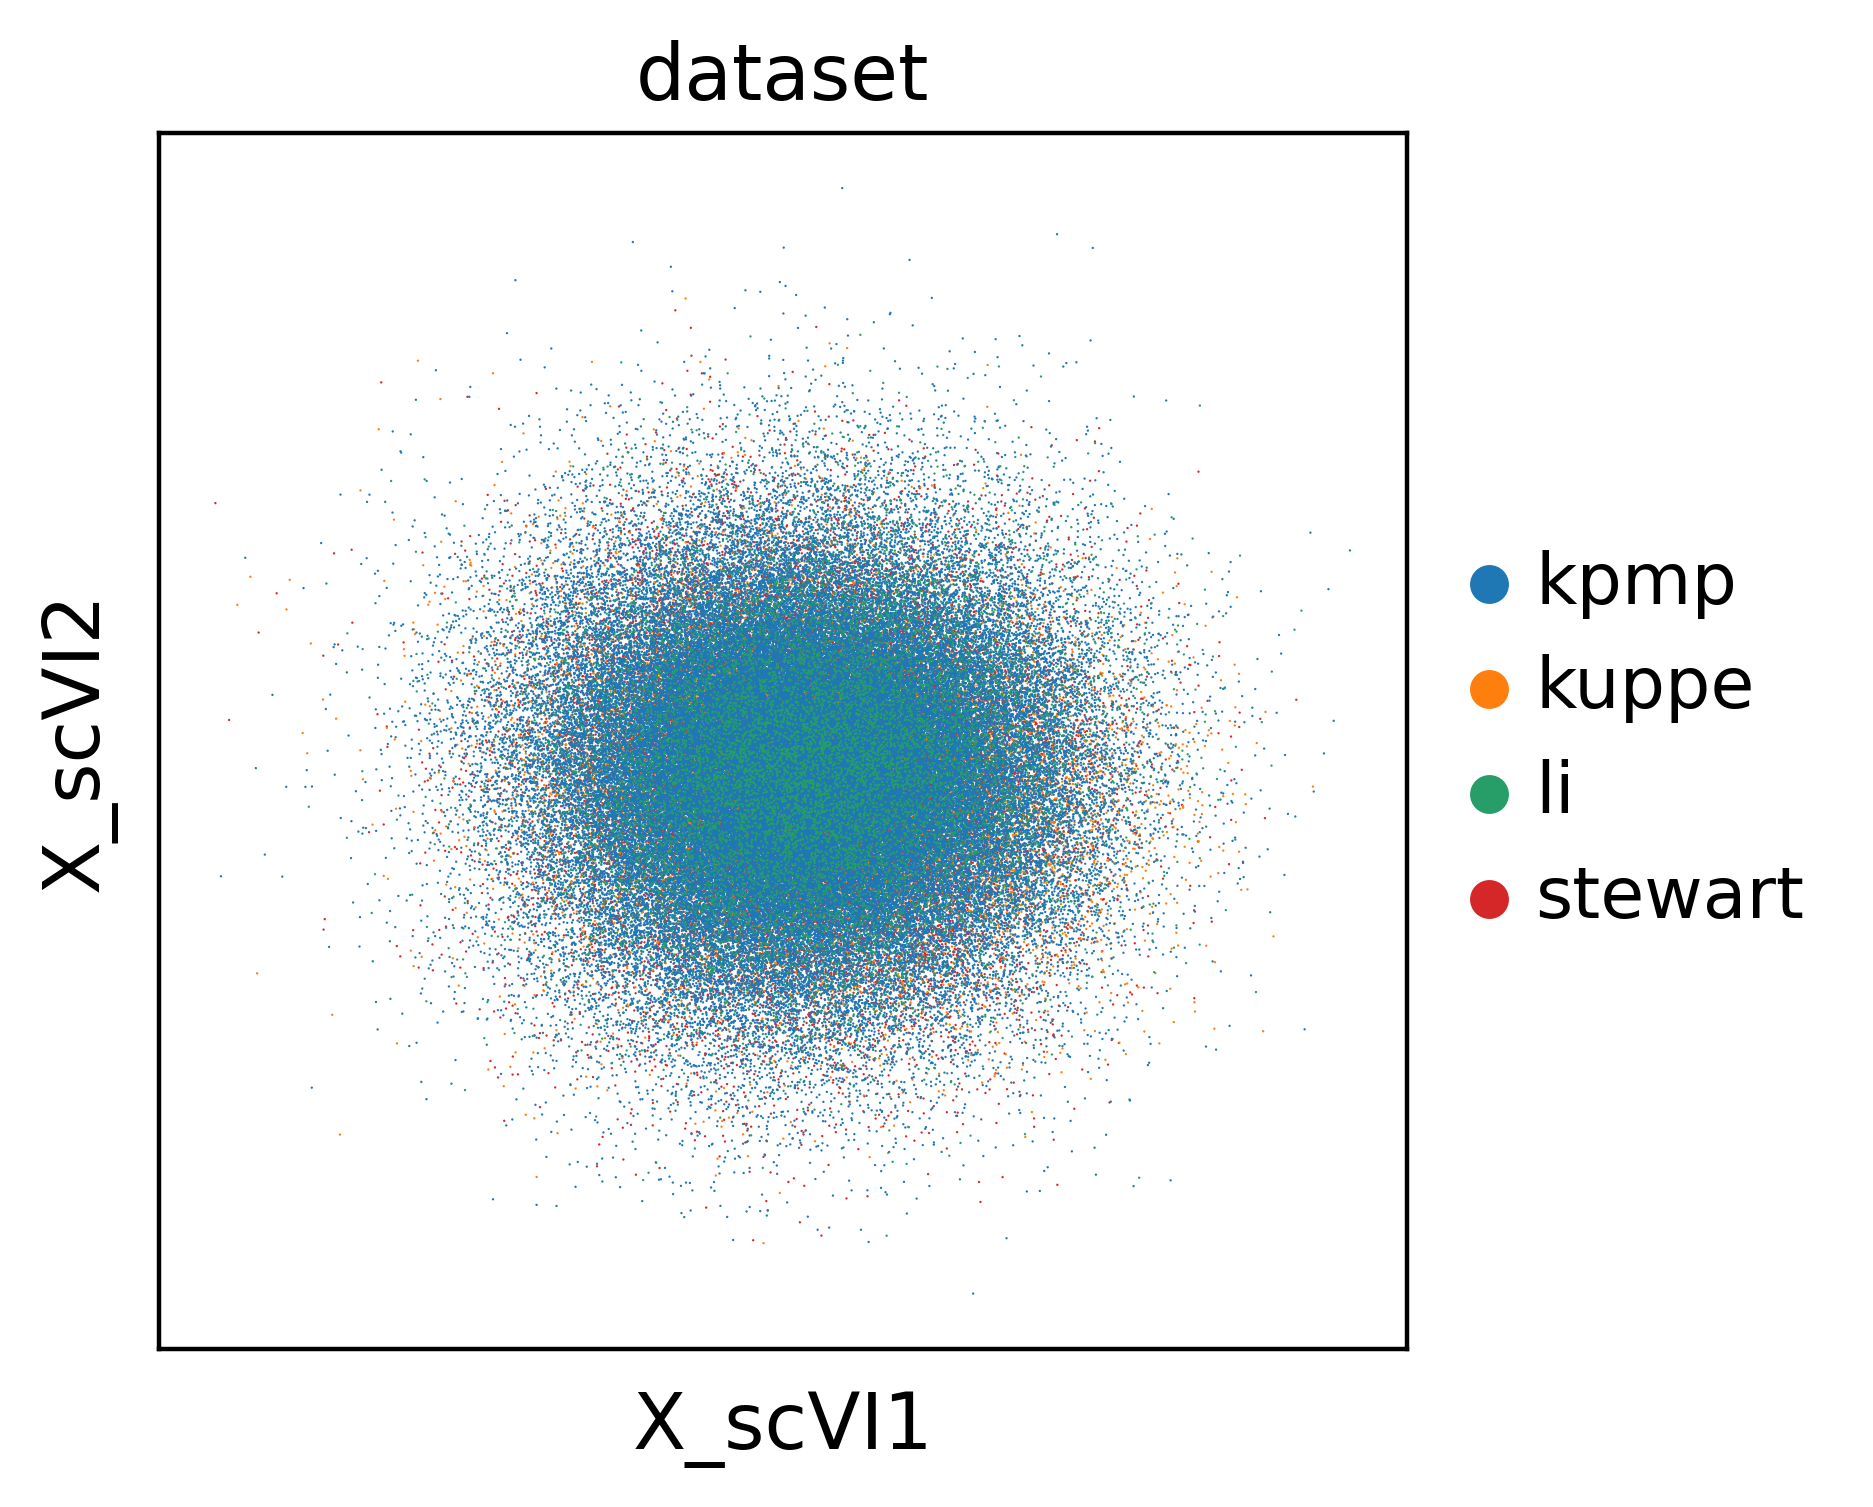

In [11]:
sc.pl.embedding(adata, basis = 'X_scVI',  color = 'dataset')

In [12]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "unknown")

In [18]:
scanvae.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:11<00:00, 35.77s/it, loss=239, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:11<00:00, 37.12s/it, loss=239, v_num=1]


In [19]:
adata.obsm['X_scANVI'] = scanvae.get_latent_representation(adata)

In [20]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/trained/public_data')
vae.save("integrated_scvi_kidney_model/", overwrite=True, save_anndata = True)
scanvae.save("integrated_scanvi_kidney_model/", overwrite=True, save_anndata = True)

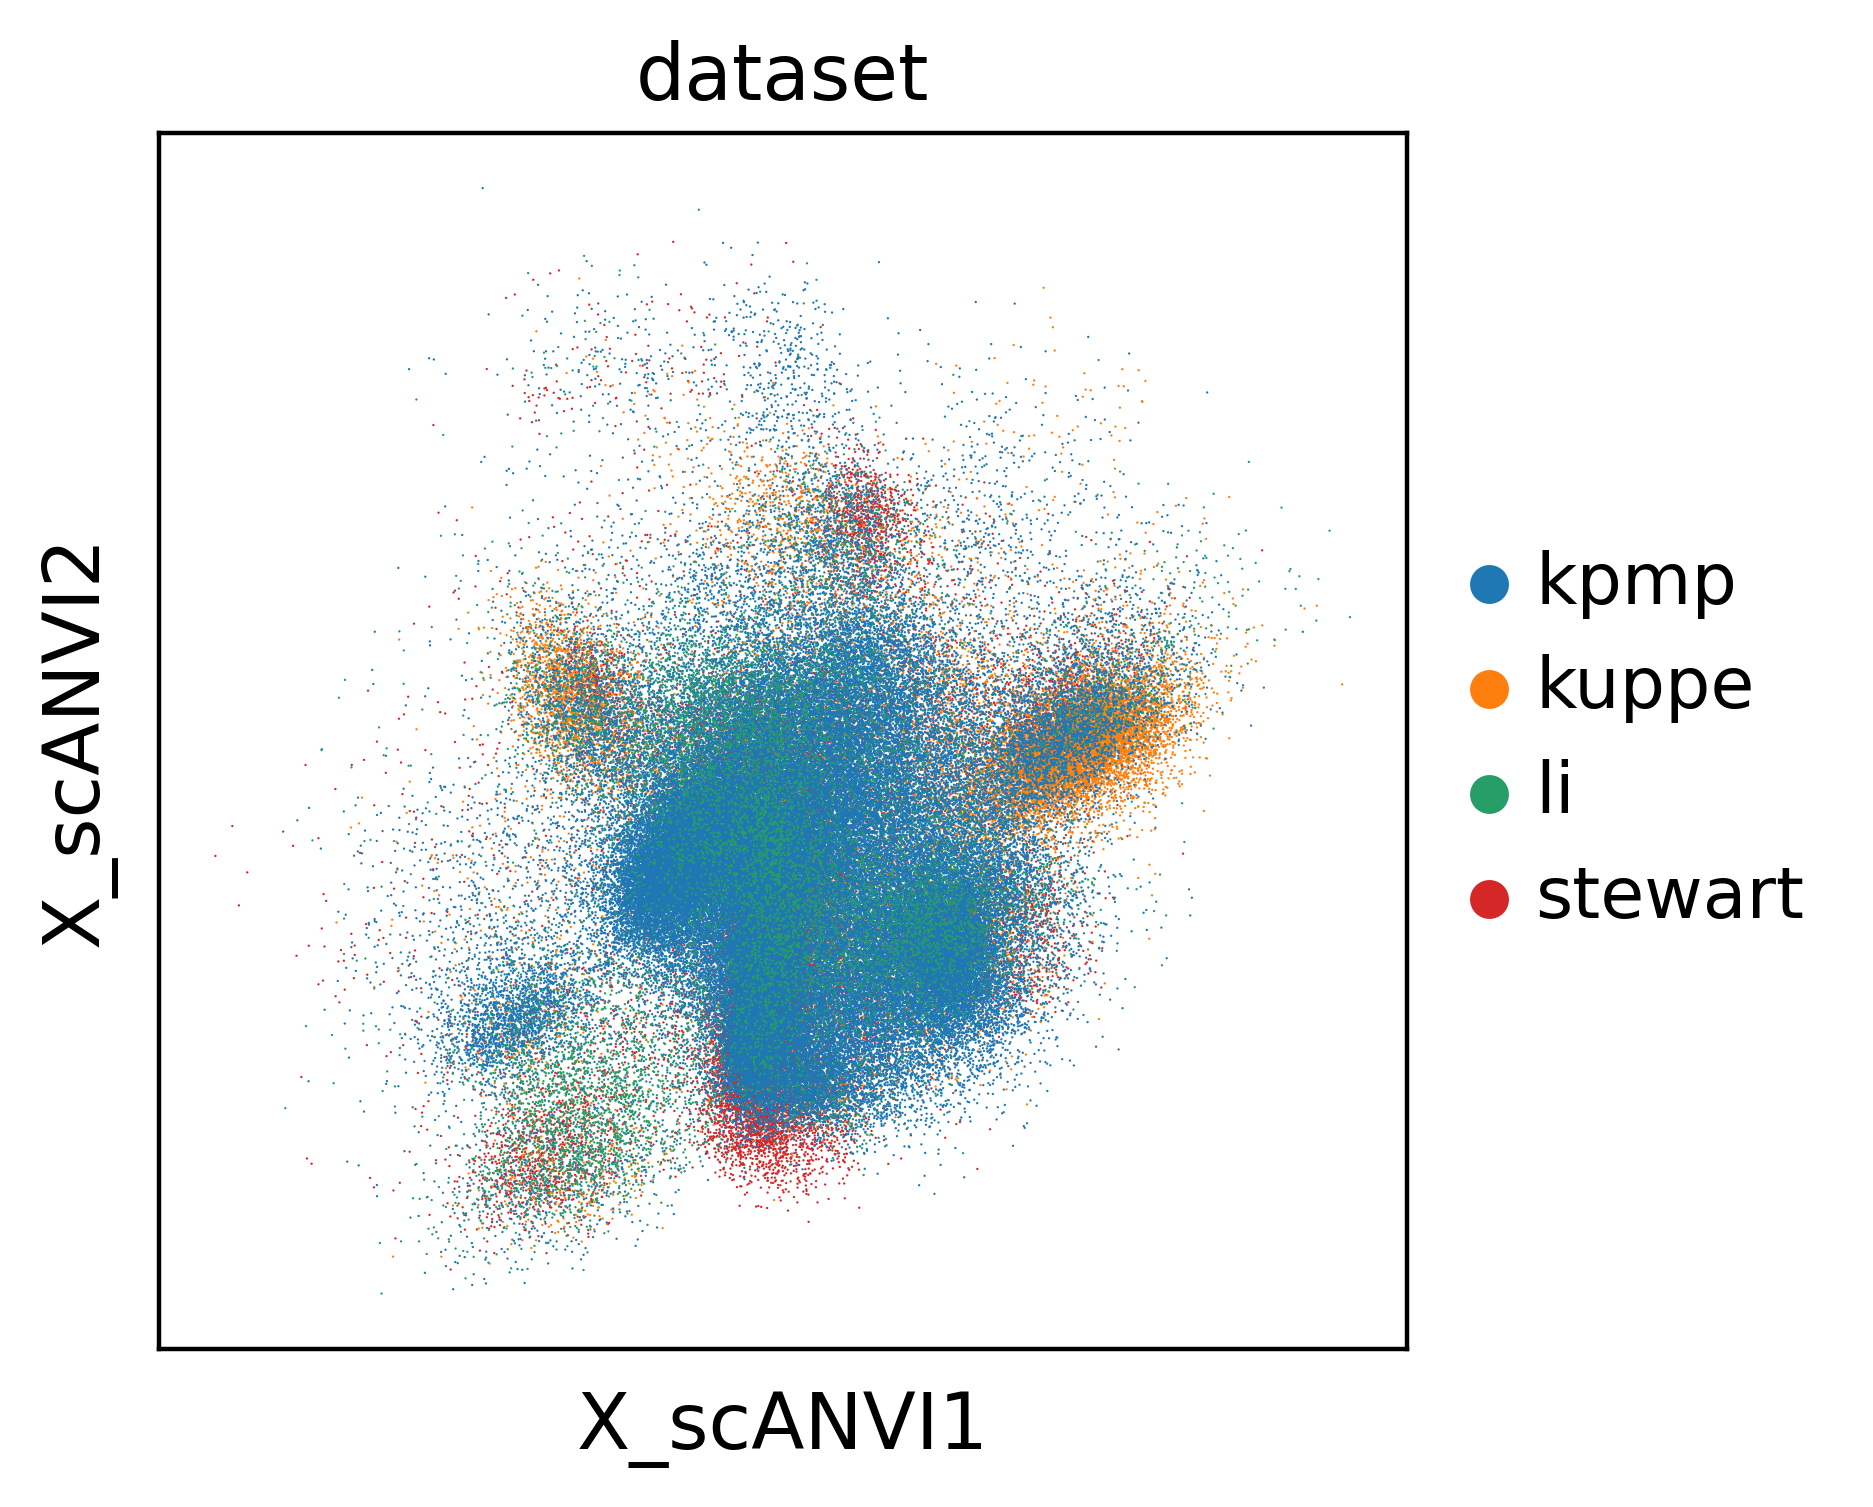

In [21]:
sc.pl.embedding(adata, basis = 'X_scANVI',  color = 'dataset')